In [2]:
import os
import sys
sys.path.append("..")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import distortion_layers as ly

from cp_toolbox.deep_learning import layers as ly

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignores warnings

### Create distortion layers

In [15]:
import tensorflow_probability as tfp
class RandomGaussianBlur(tf.keras.layers.Layer):
    """
    Layer to apply gaussian blur to image. A gaussian kernel is convolved to the input image,
    resulting in a blurred image.

    Image must be RGB [0,255] (int or float). Outputs image [0,255] (float). Input must be of
    shape [batch_size, height, width, channels].

    Attributes
        - filter_shape: (int) level of the gaussian kernel as a square. size = level * 2 + 1
        - sigma: (float) standard deviation of the gaussian kernel distribution.
        - interpolation: (str) interpolation applied for resizing
    """

    def __init__(self, filter_shape=1, sigma=1., interpolation='bilinear'):
        super(RandomGaussianBlur, self).__init__()
        self.filter_shape = filter_shape
        self.sigma = sigma
        self.interpolation = interpolation
        self.resize = None

    def build(self, input_shape):
        if self.resize is None:
            self.resize = tf.keras.layers.Resizing(
                height=input_shape[-3], width=input_shape[-2], interpolation=self.interpolation)

    def call(self,inputs, training=None):
        if training or training is None:
            return tf.map_fn(fn=self.process_input, elems=inputs)
        return inputs

    def process_input(self, input):
        i= tf.cast(input, dtype=tf.float32)
        i = i[tf.newaxis, ...]
        sigma = tf.random.uniform(shape=[], minval=0, maxval=self.sigma, dtype=tf.float32)

        gauss_kernel = self.gaussian_kernel(size=self.filter_shape[0], mean=0., std=sigma + .00001)
        gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]
        tf_image_B = tf.slice(i, [0, 0, 0, 0], [-1, -1, -1, 1])
        tf_image_G = tf.slice(i, [0, 0, 0, 1], [-1, -1, -1, 1])
        tf_image_R = tf.slice(i, [0, 0, 0, 2], [-1, -1, -1, 1])
        tf_image_B = tf.nn.conv2d(tf_image_B, gauss_kernel, strides=[1, 1, 1, 1], padding="VALID")
        tf_image_G = tf.nn.conv2d(tf_image_G, gauss_kernel, strides=[1, 1, 1, 1], padding="VALID")
        tf_image_R = tf.nn.conv2d(tf_image_R, gauss_kernel, strides=[1, 1, 1, 1], padding="VALID")
        tf_image_B = tf.squeeze(tf_image_B)
        tf_image_G = tf.squeeze(tf_image_G)
        tf_image_R = tf.squeeze(tf_image_R)
        x = tf.stack([tf_image_B, tf_image_G, tf_image_R], axis=-1)
        return self.resize(x)

    @staticmethod
    def gaussian_kernel(size: int, mean: float, std: float):
        """Makes 2D gaussian Kernel for convolution."""
        d = tfp.distributions.Normal(mean, std)
        vals = d.prob(tf.range(start=-size, limit=size + 1, dtype=tf.float32))
        gauss_kernel = tf.einsum('i,j->ij', vals, vals)
        gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
        return gauss_kernel

In [16]:
dcs = {
#     1:{
#         "contrast": {"factor": [0.2, 0.2]},
#         "color": {"factor": [5,0,5]},
#         "blur": {"filter_shape": 1, "sigma": 0.},  # kernel size is 'filter_shape * 2 + 1'
#         "brightness": {"factor": 0.3}
#     },
    1:{
        "contrast": {"factor": [0.3, 0.3]},
        "color": {"factor": [5,0,5]},
        "blur": {"filter_shape": [4,4], "sigma": 0.},  # kernel size is 'filter_shape * 2 + 1'
        "brightness": {"factor": 0.3}
#         "brightness": {"lower":1.2999, "upper":1.3}
    },
    2:{
        "contrast": {"factor": [0.3, 0.3]},
        "color": {"factor": [5,0,5]},
        "blur": {"filter_shape": [2,2], "sigma": 1.},
        "brightness": {"factor": 0.3}
#         "brightness": {"lower":0.7, "upper":1.3}
    },
    3:{
        "contrast": {"factor": [0.4, 0.6]},
        "color": {"factor": [20,0,20]},
        "blur": {"filter_shape": [2,2], "sigma": 5.},
        "brightness": {"factor": 0.5}
#         "brightness": {"lower":0.7, "upper":1.3}
    },
    4:{
        "contrast": {"factor": [0.4, 0.6]},
        "color": {"factor": [20,20,20]},
        "blur": {"filter_shape": [4,4], "sigma": 5.},
        "brightness": {"factor": 0.5}
#         "brightness": {"lower":0.7, "upper":1.3}
    }
}


layers_1 = [
    ly.DistortionLayer(layers=[
        ly.RandomColorByChannel(**dcs[i]["color"]), 
        tf.keras.layers.RandomContrast(**dcs[i]["contrast"]),
#         ly.RandomBrightness(**dcs[i]["brightness"]),
#         tf.keras.layers.RandomBrightness(**dcs[i]["brightness"]),
        ly.RandomGaussianBlur(**dcs[i]["blur"])])
    for i in dcs
]

layers_2 = [
    ly.DistortionLayer(layers=[
        ly.RandomColorByChannel(**dcs[i]["color"]), 
        tf.keras.layers.RandomContrast(**dcs[i]["contrast"]),
#         ly.RandomBrightness(**dcs[i]["brightness"]),
#         tf.keras.layers.RandomBrightness(**dcs[i]["brightness"]),
        RandomGaussianBlur(**dcs[i]["blur"])])
    for i in dcs
]


In [6]:
tf.__version__

'2.8.0'

### Load images

#### Option 1: own data set
If the notebook is ran from Docker and an absolute path wants to be provided for the train_path, make sure that the path corresponds to the docker path based on the volume used with docker run.

Otherwise, just load the data into the data folder

In [8]:
data_path = "../data"
tile_size = 128
batch_size = 20

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2
)
flow = gen.flow_from_directory(
    directory=data_path,
    target_size=(tile_size,tile_size),
    color_mode='rgb',  # 'rgb' or 'grayscale' 
    batch_size=batch_size,
)


Found 95 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

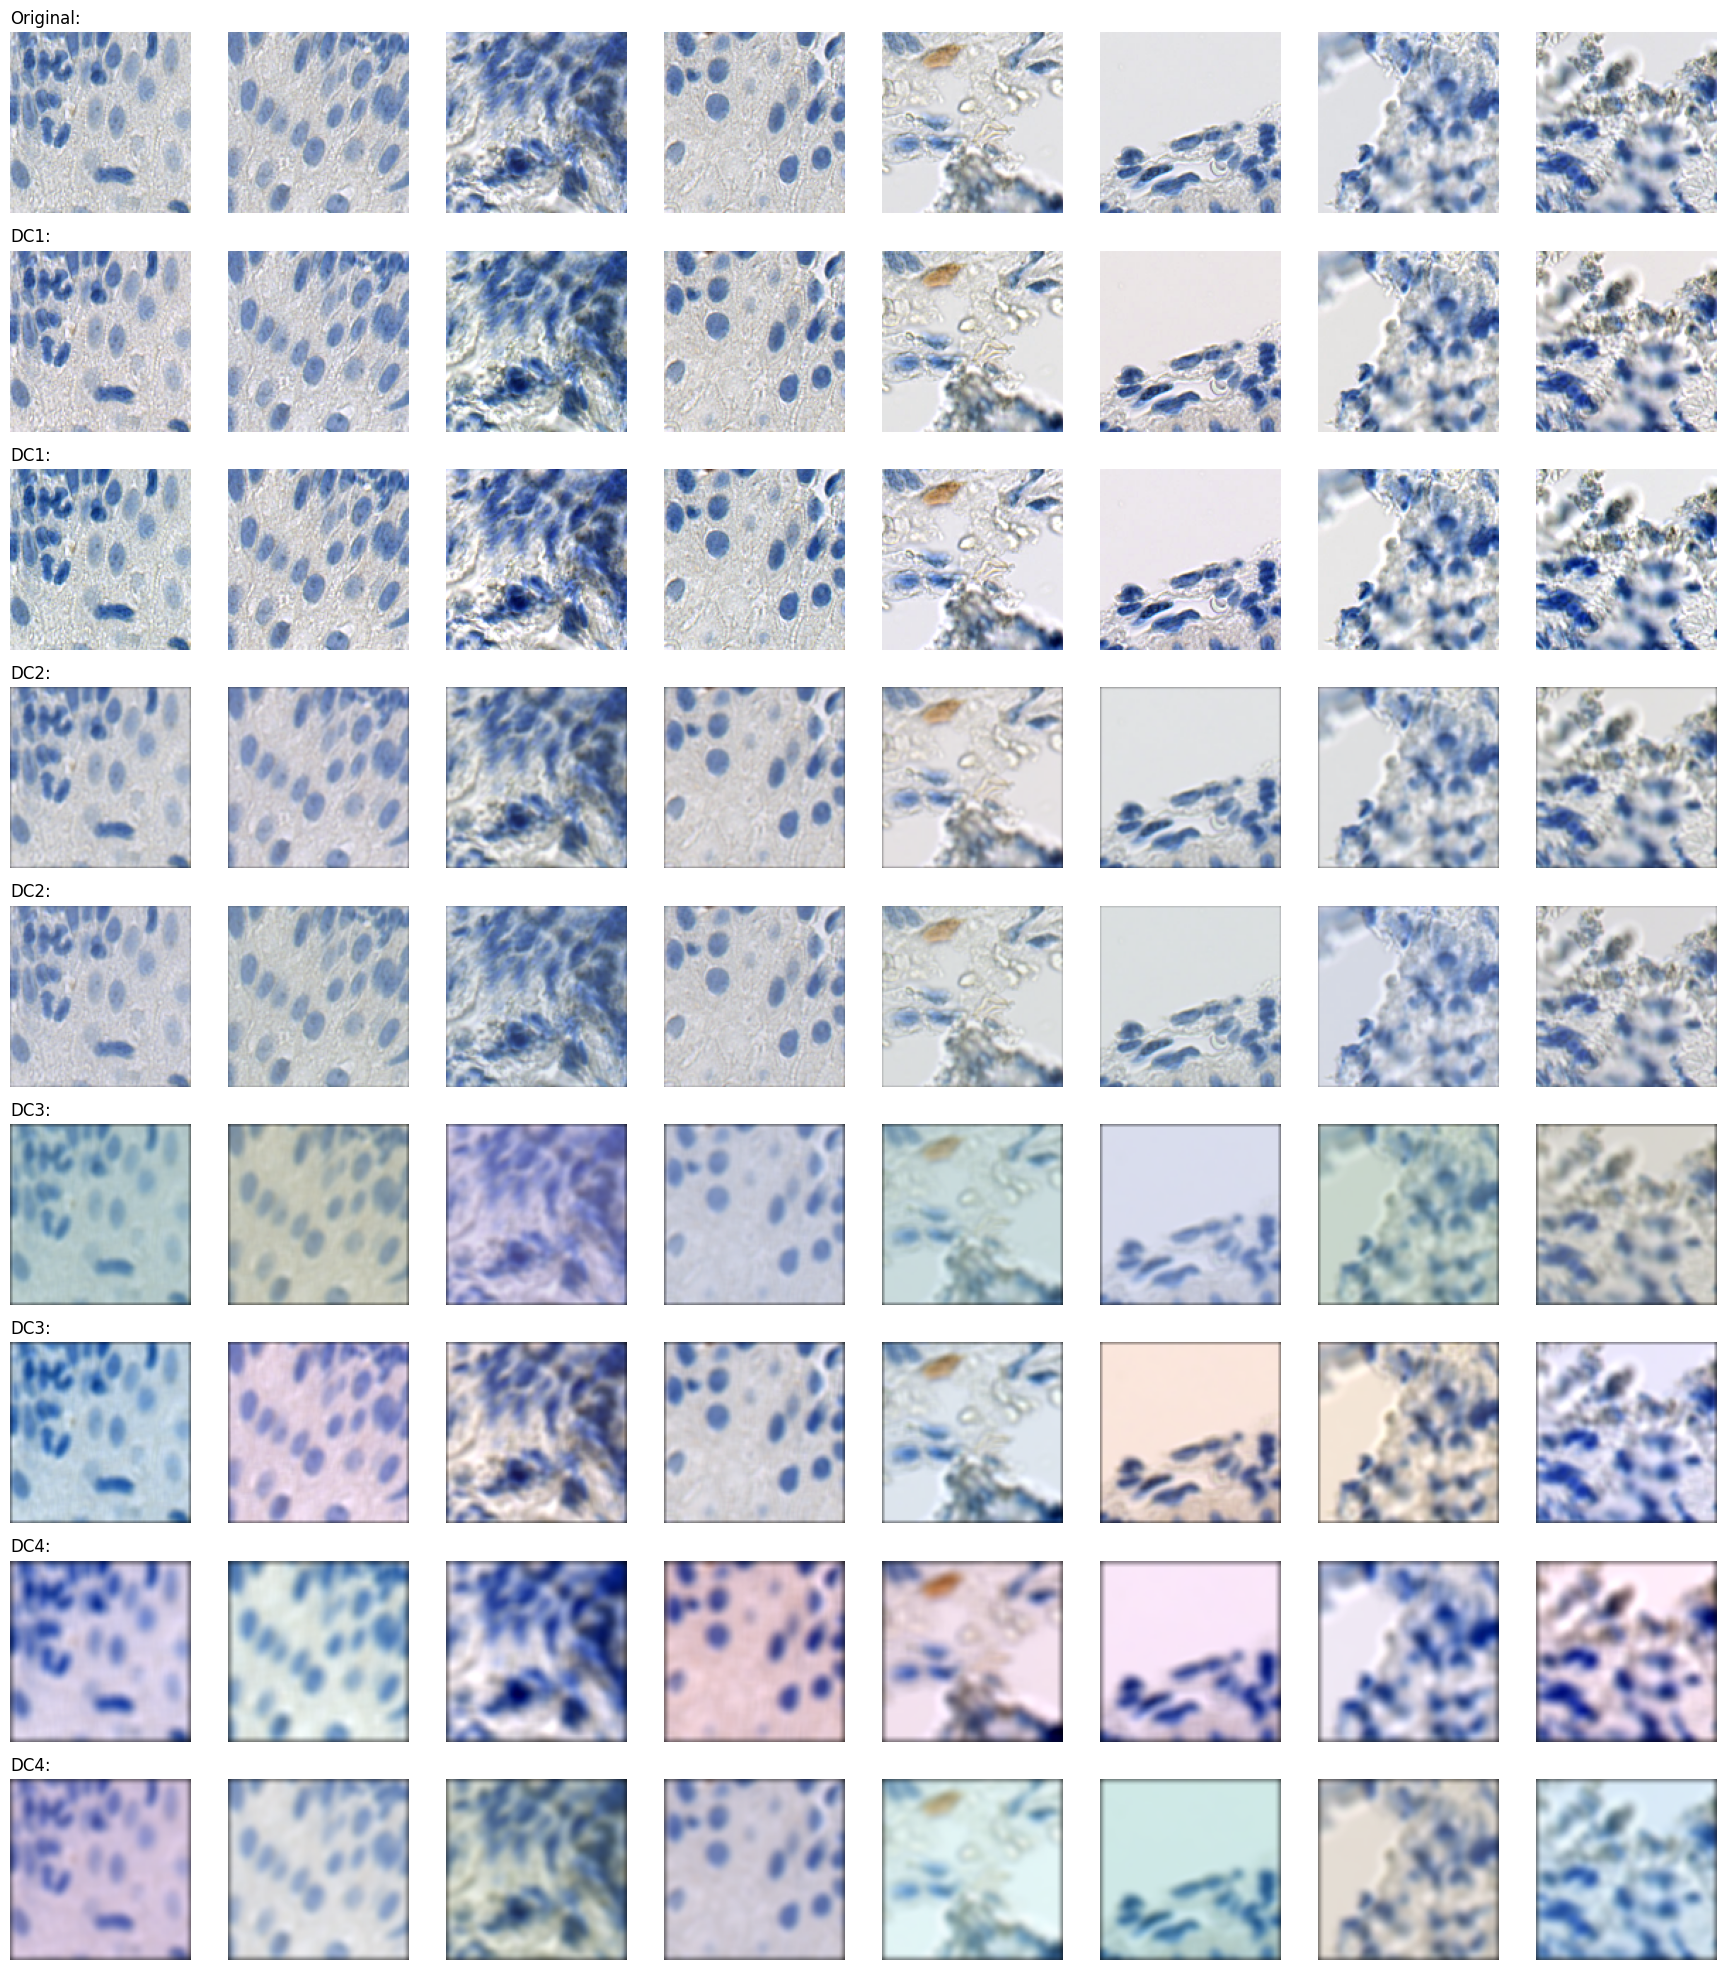

In [19]:
def visualize_augmentations(layers, num_images):
    # Sample a batch from a dataset
    batch = next(iter(flow))
    if type(batch) == tuple:
        images = batch[0][:num_images]
    else:
        images = batch[:num_images]
    # Apply augmentations
    augmented_images = zip(
        images.astype(int),
        layers[0](images).numpy().astype(int),
        layers[0](images).numpy().astype(int),
        layers[1](images).numpy().astype(int),
        layers[1](images).numpy().astype(int),
        layers[2](images).numpy().astype(int),
        layers[2](images).numpy().astype(int),
        layers[3](images).numpy().astype(int),
        layers[3](images).numpy().astype(int),
    )
    row_titles = [
        "Original:",
        "DC1:",
        "DC1:",
        "DC2:",
        "DC2:",
        "DC3:",
        "DC3:",
        "DC4:",
        "DC4:",
    ]
    plt.figure(figsize=(num_images * 2.2, 9 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(9, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(layers_1, num_images=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


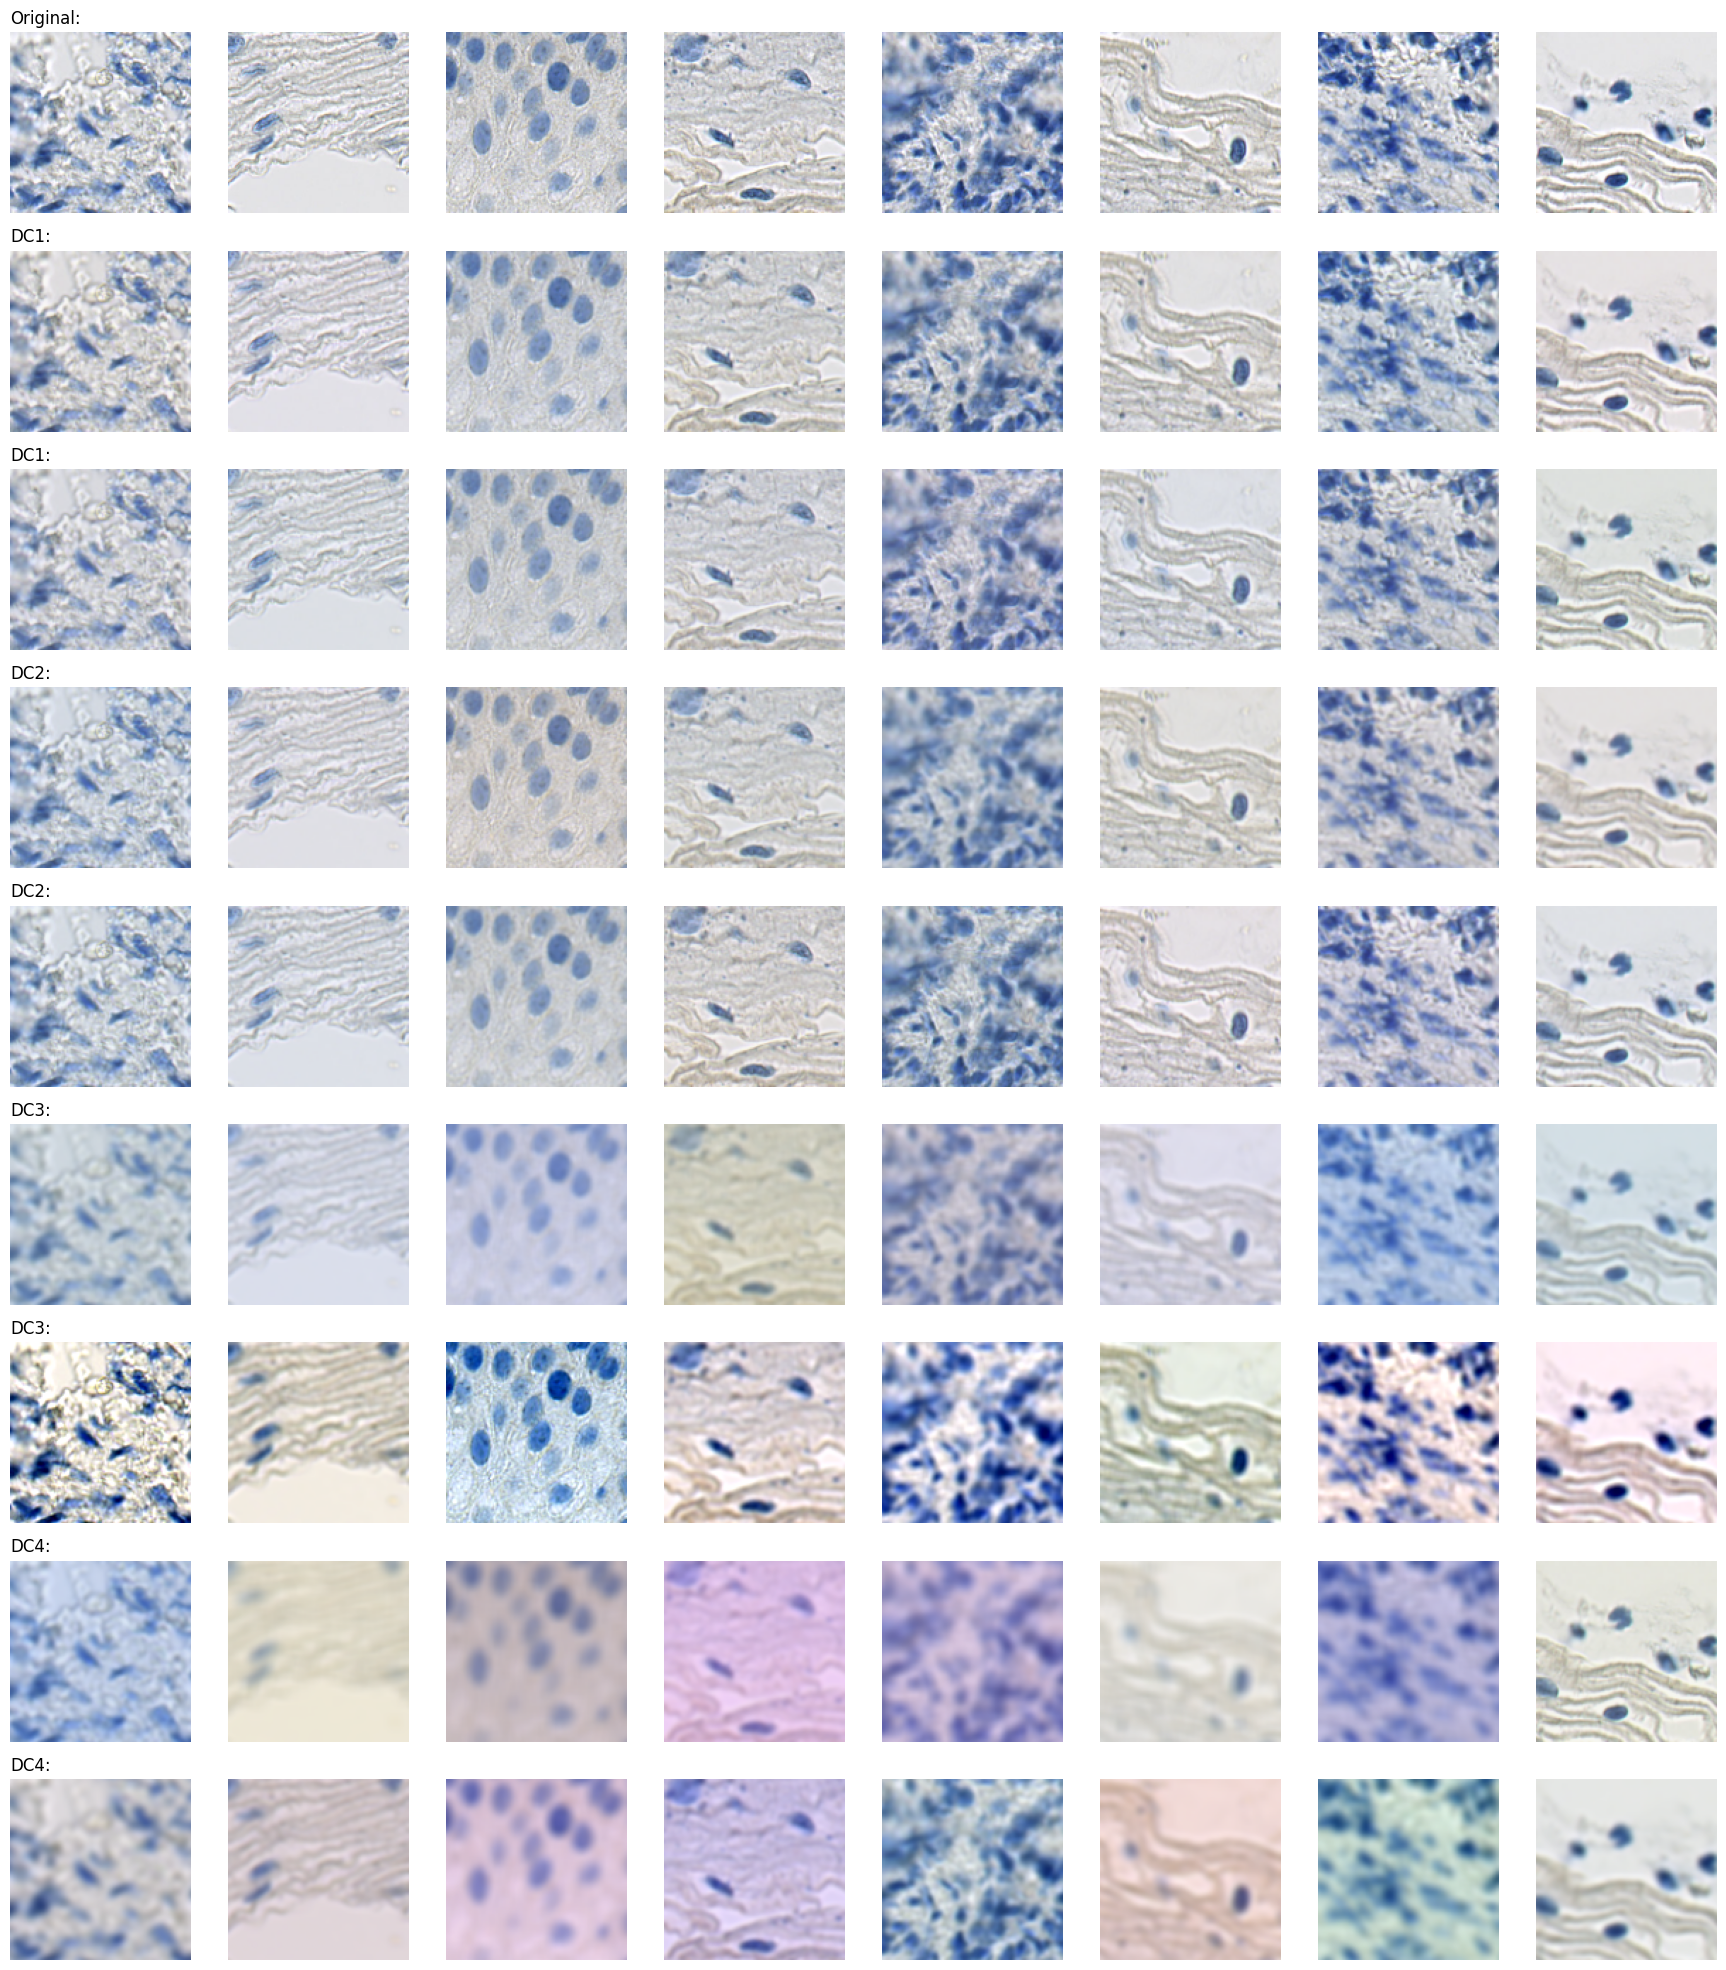

In [20]:
visualize_augmentations(layers_2, num_images=8)

#### Option 2: try it on cifar